In [3]:
import numpy as np
npa = np.array
import pandas as pd
import matplotlib.pylab as plt

from sklearn.decomposition import PCA

from IPython.display import display, clear_output

import json

,x,y,z
t,,,
1509305471110,1.258,4.191,8.026
1509305471110,1.258,4.191,8.026
1509305471110,1.258,4.191,8.026
1509305471129,1.295,4.246,8.901
1509305471149,1.174,4.397,8.925


,event
t,
1509305495112,1.0
1509305496724,1.0
1509305498405,1.0
1509305499972,1.0
1509305501845,1.0


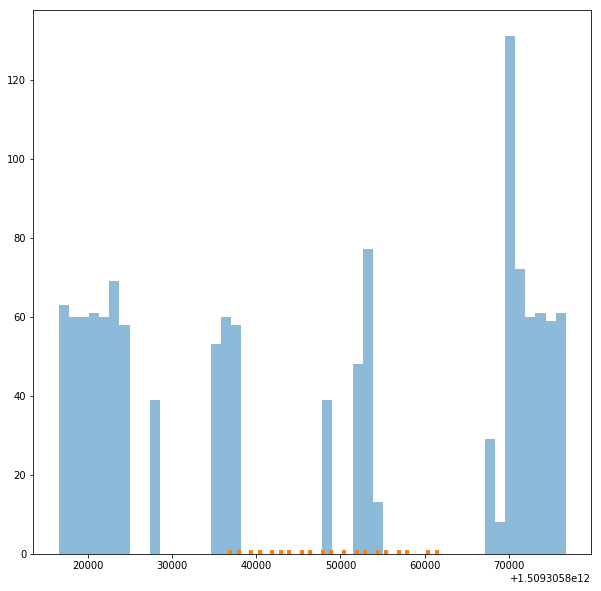

In [66]:
def read_txyz_json(fname):
    with open(fname) as f:
        j = json.load(f)
        keys = list(j[0].keys())
        data = dict([(key, []) for key in keys])
        for line in j:
            for x in line.items():
                data[x[0]].append(x[1])
        data = pd.DataFrame(data)
        data.set_index(keys[0], inplace=True)
    return data
        
def read_t_json(fname):
    with open(fname) as f:
        j = json.load(f)
        data = [int(t) for t in j]
        data = pd.DataFrame({"t": data, "event": np.ones(len(data))})
        data.set_index("t", inplace=True)
    return data

def read_data_v2(path):
    return read_txyz_json(path + "/log.txt"), read_t_json(path + "/marker.txt")
    
display(read_txyz_json("data/1/log.txt").head())
display(read_t_json("data/1/marker.txt").head())

plt.figure(figsize=(10, 10))
plt.hist(read_txyz_json("data/2/log.txt").index, bins=50, alpha=0.5)
plt.hist(read_t_json("data/2/marker.txt").index, bins=50)
plt.show()

In [52]:
# assumes that 2 coord is biggest
def calc_rotatation_down(h):
    bh = h
    h = np.matrix(np.array(h)).T
    sign_m = np.matrix(np.diag([1 if x >= 0 else -1 for x in list(np.array(h).ravel())]))
    h = sign_m * h
    sort_m = np.matrix(np.array([
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
    ]))
    h = sort_m * h
    phi = np.arctan2(np.array(h).ravel()[0], np.array(h).ravel()[2])
    s, c = np.sin(phi), np.cos(phi)
    zero1st_m = np.matrix(np.array([
        [c, 0, -s],
        [0, 1, 0],
        [s, 0, c],
    ]))
    h = zero1st_m * h
    phi = np.arctan2(np.array(h).ravel()[1], np.array(h).ravel()[2])
    s, c = np.sin(phi), np.cos(phi)
    zero2nd_m = np.matrix(np.array([
        [1, 0, 0],
        [0, c, -s],
        [0, s, c],
    ]))
    h = zero2nd_m * h
    
    print("calc_rotation:", bh, " -> ", np.array(h).ravel())
    return zero2nd_m * zero1st_m * sort_m * sign_m

def align_down(xyz):
    xyz = xyz.copy()
    h = [xyz.iloc[:, i].mean() for i in range(3)]
    m = calc_rotatation_down(h)
    for index, row in xyz.iterrows():
        row[:] = np.array(m * np.matrix(np.array(row[:])).T).ravel()
    return xyz


def unite_data(accel, event):
    #accel = align_down(accel)
    # pd.concat doesn't work =(
    data = accel.join(event, how='outer')
    data.index -= data.index.min()
#     for j in range(len(data.columns) - 1):
#         prev_val = 0
#         nan_cnt = 0
#         for i in range(0, len(data)):
#             if not np.isnan(data.iloc[i, j]):
#                 cur_val = data.iloc[i, j]
#                 if nan_cnt > 0:
#                     for k in range(1, nan_cnt + 1):
#                         data.iloc[i - k, j] = cur_val + (prev_val - cur_val) * k / (nan_cnt + 1)
#                 nan_cnt = 0
#                 prev_val = cur_val
#             else:
#                 nan_cnt += 1                
#     data.fillna(0, inplace=True)
    return data

    
def load_and_unite_data(path):
    xyz, event = read_data_v2(path)
    return unite_data(xyz, event)

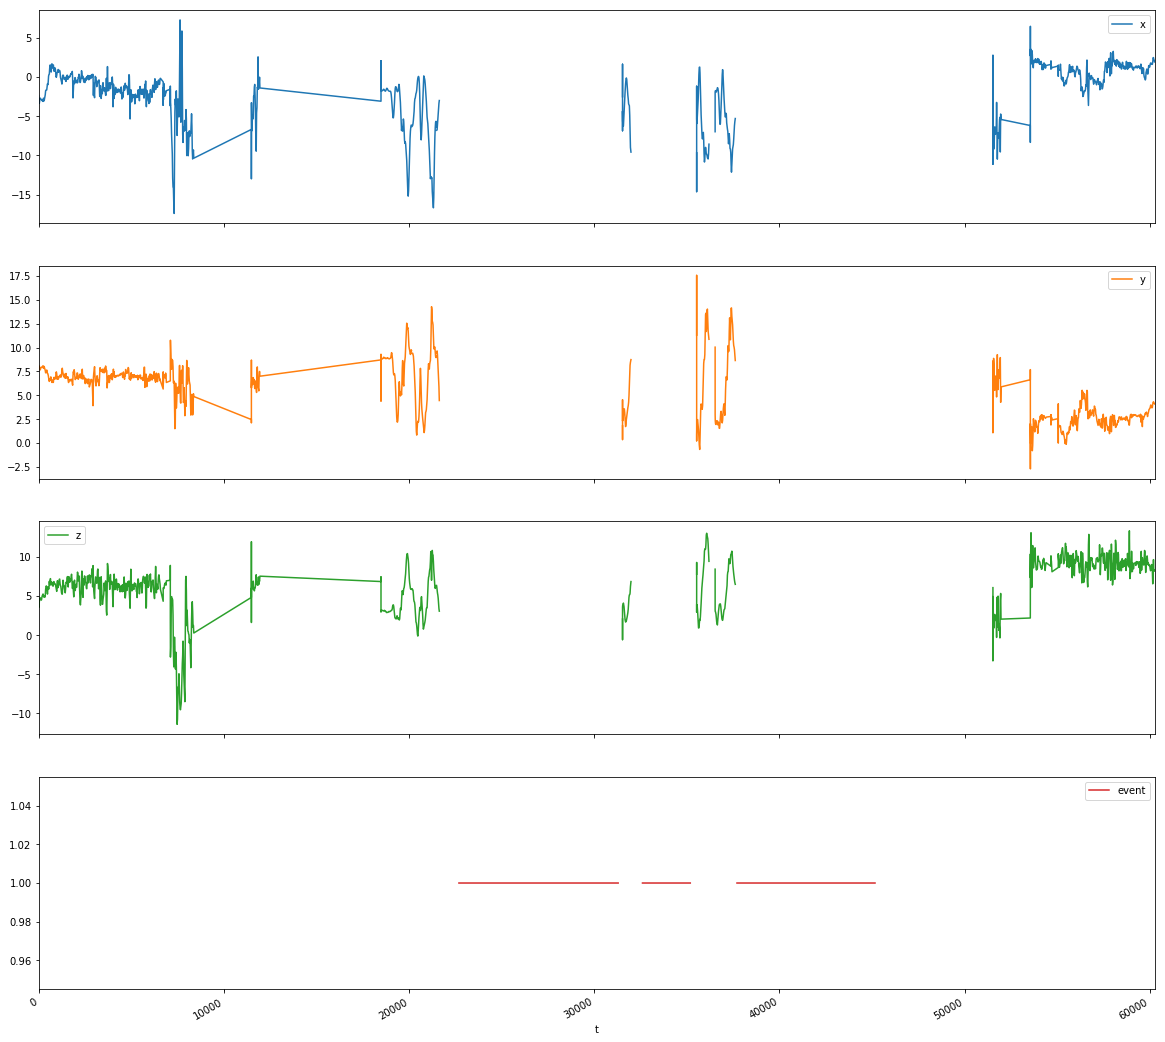

In [53]:
data = load_and_unite_data("data/2")
data.plot(figsize=(20, 20), subplots=True)
plt.show()

In [39]:

    

def stepKickData(fname):
    ts = list(map(int, open(fname, 'r').readline()[1:-2].split(',')))
    kicks = pd.DataFrame({"TIME": ts})
    kicks.set_index("TIME", inplace=True)
    return kicks

In [131]:
def pca_it(xyz, pcator=None):
    xyz = xyz.copy()
    xyz.iloc[:,:] -= xyz.values.mean(axis=0)
    if pcator is None:
        pcator = PCA(n_components=3)
        pcator.fit(xyz.values)
    xyz.iloc[:,:] = pcator.transform(xyz.values)
    return (xyz, pcator)
    
# assumes that 2 coord is biggest
def calc_rotatation_down(h):
    bh = h
    h = np.matrix(np.array(h)).T
    sign_m = np.matrix(np.diag([1 if x >= 0 else -1 for x in list(np.array(h).ravel())]))
    h = sign_m * h
    sort_m = np.matrix(np.array([
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
    ]))
    h = sort_m * h
    phi = np.arctan2(np.array(h).ravel()[0], np.array(h).ravel()[2])
    s, c = np.sin(phi), np.cos(phi)
    zero1st_m = np.matrix(np.array([
        [c, 0, -s],
        [0, 1, 0],
        [s, 0, c],
    ]))
    h = zero1st_m * h
    phi = np.arctan2(np.array(h).ravel()[1], np.array(h).ravel()[2])
    s, c = np.sin(phi), np.cos(phi)
    zero2nd_m = np.matrix(np.array([
        [1, 0, 0],
        [0, c, -s],
        [0, s, c],
    ]))
    h = zero2nd_m * h
    
    print("calc_rotation:", bh, " -> ", np.array(h).ravel())
    return zero2nd_m * zero1st_m * sort_m * sign_m

def align_down(xyz):
    xyz = xyz.copy()
    h = [xyz.iloc[:, i].mean() for i in range(3)]
    m = calc_rotatation_down(h)
    for index, row in xyz.iterrows():
        row[:] = np.array(m * np.matrix(np.array(row[:])).T).ravel()
    return xyz

In [132]:
def prepare_xyz(xyz, prefix=""):    
    xyz.columns = [prefix + name for name in xyz.columns]
    return xyz
    
def prepare_events(ts, column_name):
    ts = ts.copy()
    ts[column_name] = np.ones(len(ts)).astype('int')
    return ts
    
def unite_data(accel, gyro, steps):
    gyro = prepare_xyz(gyro, "gyro_")
    accel = prepare_xyz(accel, "accel_")
    accel = align_down(accel)
    steps = prepare_events(steps, "step")
    
    # pd.concat doesn't work =(
    data = accel.join(gyro, how='outer').join(steps, how='outer')
    
    data.index -= data.index.min()
    for j in range(len(data.columns) - 1):
        prev_val = 0
        nan_cnt = 0
        for i in range(0, len(data)):
            if not np.isnan(data.iloc[i, j]):
                cur_val = data.iloc[i, j]
                if nan_cnt > 0:
                    for k in range(1, nan_cnt + 1):
                        data.iloc[i - k, j] = cur_val + (prev_val - cur_val) * k / (nan_cnt + 1)
                nan_cnt = 0
                prev_val = cur_val
            else:
                nan_cnt += 1
                
    data.fillna(0, inplace=True)
            
    data.dropna(inplace=True)

    
    return data


In [133]:
accel, gyro = readAccData("data/accData.txt")
xs = accel.index
kicks = stepKickData("data/stepKickData.txt")

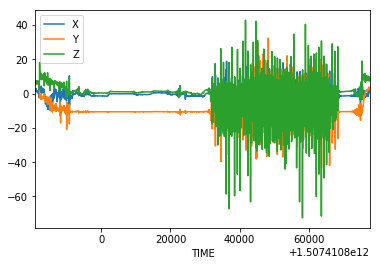

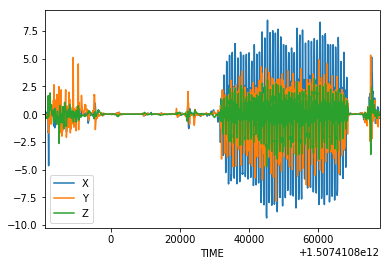

In [134]:
accel.plot()
#plt.xlim(78000, 81000)
plt.show()
gyro.plot()
#plt.xlim(78000, 81000)
plt.show()



In [135]:
united = unite_data(accel, gyro, kicks)

calc_rotation: [-0.69748301199896956, -10.457151568777, 0.5300895243915541]  ->  [ -1.11022302e-16   0.00000000e+00   1.04937837e+01]


In [136]:
united.corr()

,accel_X,accel_Y,accel_Z,gyro_X,gyro_Y,gyro_Z,step
accel_X,1.000000,0.335536,-0.127809,-0.152950,-0.370510,-0.034607,0.021354
accel_Y,0.335536,1.000000,-0.363106,-0.165006,-0.030008,-0.130559,-0.024844
accel_Z,-0.127809,-0.363106,1.000000,-0.168572,0.209979,-0.239491,0.076950
gyro_X,-0.152950,-0.165006,-0.168572,1.000000,-0.153908,0.863034,-0.090894
gyro_Y,-0.370510,-0.030008,0.209979,-0.153908,1.000000,-0.438139,0.066221
gyro_Z,-0.034607,-0.130559,-0.239491,0.863034,-0.438139,1.000000,-0.107249
step,0.021354,-0.024844,0.076950,-0.090894,0.066221,-0.107249,1.000000


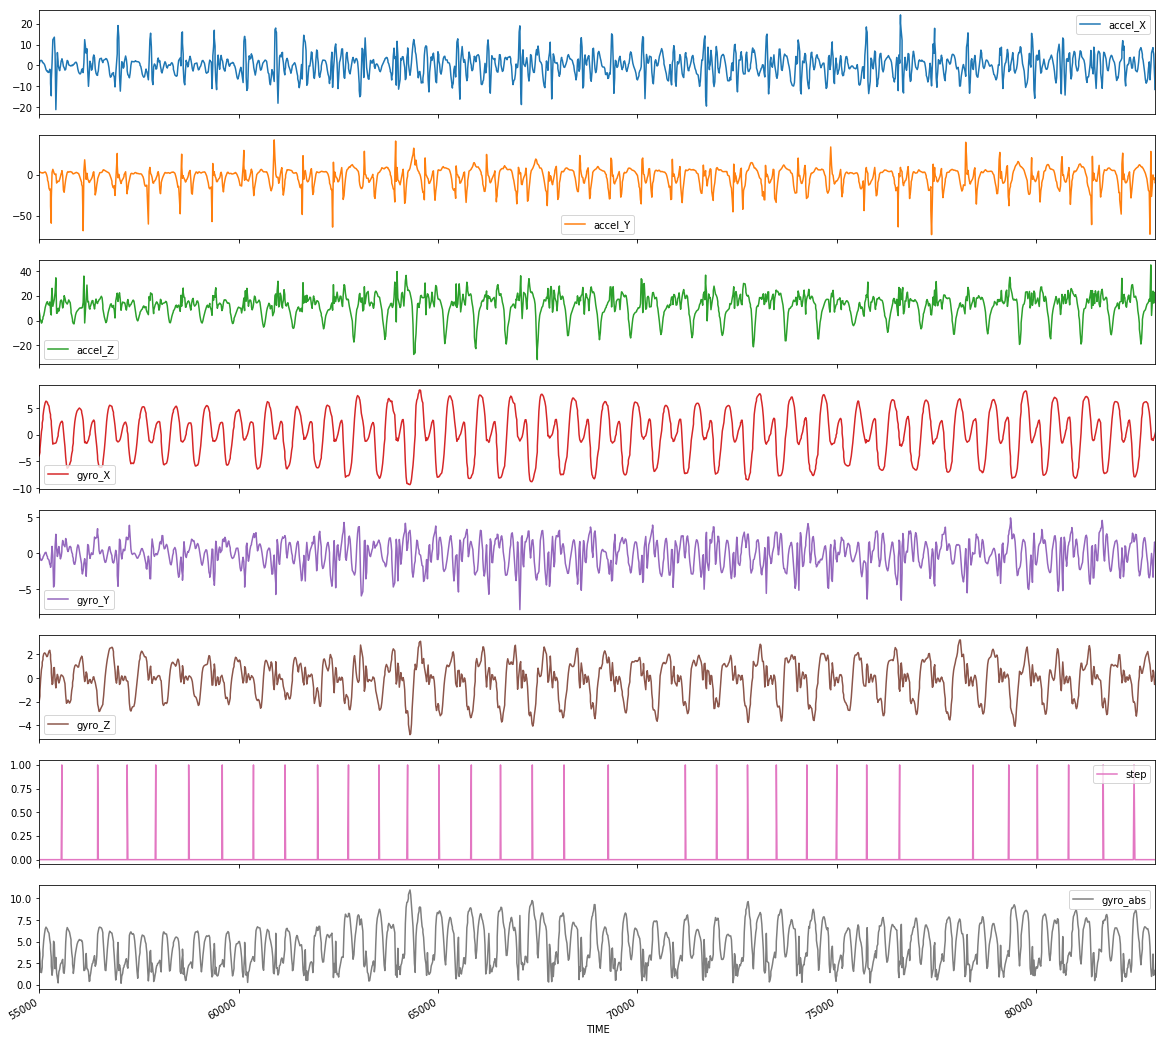

In [143]:
#united["gyro_abs"] = np.sqrt((npa(united.iloc[:, 3:6]) ** 2).sum(axis=1))
united.plot(figsize=(20, 20), subplots=True)
plt.xlim(55000, 83000)
plt.show()

In [49]:
d["accel_Y"].mean()

9.741802718219025e-18

In [139]:
display(united["accel_X"].mean())
display(united["accel_Y"].mean())
display(united["accel_Z"].mean())

0.020083222062956249

-0.061057273730262873

10.5630195596944

In [125]:
h = [-0.77, -10.52, 0.47]

def calc_rotatation_down(h):
    bh = h
    h = np.array(h)
    sign_m = np.matrix(np.diag([1 if x >= 0 else -1 for x in list(np.array(h).ravel())]))
    h = np.dot(sign_m, h)
    display(h.flatten())
    sort_m = np.matrix(np.array([
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
    ]))
    h = np.dot(sort_m, h)
    phi = np.arctan2(np.array(h).ravel()[0], np.array(h).ravel()[2])
    s, c = np.sin(phi), np.cos(phi)
    zero1st_m = np.matrix(np.array([
        [c, 0, -s],
        [0, 1, 0],
        [s, 0, c],
    ]))
    h = np.dot(zero1st_m, h)
    phi = np.arctan2(np.array(h).ravel()[1], np.array(h).ravel()[2])
    s, c = np.sin(phi), np.cos(phi)
    zero2nd_m = np.matrix(np.array([
        [1, 0, 0],
        [0, c, -s],
        [0, s, c],
    ]))
    h = np.dot(zero2nd_m, h)
    
    print("calc_rotation:", bh, " -> ", np.array(h).ravel())
    return zero2nd_m * zero1st_m * sort_m * sign_m
    
calc_rotatation_down(h)

matrix([[  0.77,  10.52,   0.47]])

ValueError: shapes (3,3) and (1,3) not aligned: 3 (dim 1) != 1 (dim 0)

In [66]:
np.

matrix([[  0.77],
        [ 10.52],
        [  0.47]])

In [ ]:
np.arc